In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import numpy as np
from tqdm import tqdm
import scipy.stats as stats
from scipy.signal import find_peaks, peak_widths
import itertools
import pandas as pd
# import pymc3 as pm
# import arviz as az
from datetime import datetime as dt
# import igraph as ig
# from statsmodels.stats.weightstats import ztest
from rdkit import Chem
from rdkit.Chem import Descriptors
import os

In [2]:
plt.style.use("default")
plt.rcParams.update({'font.size': 22})

palette = ["#e072b5",
"#69b15f",
"#737df6",
"#c79737",
"#b67ae4",
"#e57368",
"#799ddb"]

# Chemical properties figure

- MA changes
- MW change
- Novel fragments

## Set up MA section

In [3]:
#Load compound dates

fp = "/Volumes/Macintosh HD 4/SureChemBL/CpdPatentIdsDates/Cpd_Date_Dict/"

cpd_dates_FULL = pickle.load(file=open(fp + "cpd_date_dict_FULL.p", "rb"))

In [4]:
#Load all assemblyGo results

MA_df = pd.read_csv("../Data/AssemblyValues/ALLSAMPLEDcpds_AssemblyGo.csv")

Get earliest date for compounds

In [5]:
def get_earliest_date(ID, cpd_dates_FULL):
    if ID in cpd_dates_FULL:
        return cpd_dates_FULL[ID][0]
    else:
        return None

In [6]:
tqdm.pandas()

MA_df["earliest_date"] = MA_df["label"].progress_apply(get_earliest_date, args=(cpd_dates_FULL,))

100%|██████████| 2033834/2033834 [00:06<00:00, 311132.06it/s]


Convert dates to datetime objects

In [7]:
import datetime as dt

MA_df["earliest_date"] = pd.to_datetime(MA_df["earliest_date"])
MA_df["date_ordinal"] = MA_df["earliest_date"].map(dt.datetime.toordinal)

In [8]:
print(MA_df)

         Unnamed: 0  Unnamed: 0.1            label  MA_assemblyGo        time  \
0                 0             0        SCHEMBL10           21.0  120.662484   
1                 1             1  SCHEMBL10000006           14.0  119.968879   
2                 2             2  SCHEMBL10000077           19.0  119.948782   
3                 3             3  SCHEMBL10000078           10.0   28.798358   
4                 4             4  SCHEMBL10000080            6.0    0.351274   
...             ...           ...              ...            ...         ...   
2033829      473226         13048  SCHEMBL21609983           25.0         NaN   
2033830      473227         13049  SCHEMBL21610001            7.0         NaN   
2033831      473228         13050  SCHEMBL21610027          133.0         NaN   
2033832      473229         13051  SCHEMBL21610072            8.0         NaN   
2033833      473231         13053  SCHEMBL21610114           27.0         NaN   

        earliest_date  date

Get MA values and statistics from each month

In [8]:
def get_month(label):
    """ Isolates the month from the given label

    Args:
        label (str): compound id in the form YYYY-MM_label

    Returns:
        str: YYYY-MM of a particular compound
    """
    return str(label)[:7]

In [9]:
tqdm.pandas()

MA_df["month"] = MA_df["earliest_date"].progress_apply(get_month)

100%|██████████| 2033834/2033834 [00:28<00:00, 71417.37it/s] 


In [10]:
MA_df_months = MA_df.groupby("month")["MA_assemblyGo"].apply(list).reset_index(name="MAs")

print(MA_df_months)

       month                                                MAs
0    1965-02                                       [17.0, 18.0]
1    1965-05                                              [7.0]
2    1965-06                                              [9.0]
3    1966-03                                              [6.0]
4    1966-07                                              [6.0]
..       ...                                                ...
580  2020-09  [23.0, 21.0, 17.0, 17.0, 8.0, 26.0, 18.0, 12.0...
581  2020-10  [10.0, 10.0, 9.0, 12.0, 19.0, 17.0, 9.0, 11.0,...
582  2020-11  [11.0, 13.0, 8.0, 14.0, 12.0, 11.0, 11.0, 13.0...
583  2020-12  [9.0, 46.0, 14.0, 46.0, 7.0, 47.0, 41.0, 41.0,...
584      NaT  [nan, 12.0, 17.0, 7.0, 9.0, 9.0, 27.0, 12.0, 1...

[585 rows x 2 columns]


In [11]:
def get_mean(MAs):
    try:
        return np.mean(MAs)
    except:
        return 0
    
def get_std(MAs):
    try:
        return np.std(MAs)
    except:
        return 0
    
def get_IQR(MAs):
    try:
        return stats.iqr(MAs, interpolation="midpoint")
    except:
        return 0

In [12]:
tqdm.pandas() 

MA_df_months["avg"] = MA_df_months["MAs"].progress_apply(get_mean)
MA_df_months["std"] = MA_df_months["MAs"].progress_apply(get_std)
MA_df_months["iqr"] = MA_df_months["MAs"].progress_apply(get_IQR)

100%|██████████| 585/585 [00:00<00:00, 1508.86it/s]


In [13]:
MA_df_months["date"] = pd.to_datetime(MA_df_months["month"])
MA_df_months["date_ordinal"] = MA_df_months["date"].map(dt.datetime.toordinal)

In [34]:
print(MA_df_months)

       month                                                MAs        avg  \
0    1965-02                                       [17.0, 18.0]  17.500000   
1    1965-05                                              [7.0]   7.000000   
2    1965-06                                              [9.0]   9.000000   
3    1966-03                                              [6.0]   6.000000   
4    1966-07                                              [6.0]   6.000000   
..       ...                                                ...        ...   
580  2020-09  [23.0, 21.0, 17.0, 17.0, 8.0, 26.0, 18.0, 12.0...  22.940089   
581  2020-10  [10.0, 10.0, 9.0, 12.0, 19.0, 17.0, 9.0, 11.0,...  23.913058   
582  2020-11  [11.0, 13.0, 8.0, 14.0, 12.0, 11.0, 11.0, 13.0...  22.986283   
583  2020-12  [9.0, 46.0, 14.0, 46.0, 7.0, 47.0, 41.0, 41.0,...  23.890889   
584      NaT  [nan, 12.0, 17.0, 7.0, 9.0, 9.0, 27.0, 12.0, 1...        NaN   

           std   iqr       date  date_ordinal  
0     0.500000 

Text(0, 0.5, 'Assembly Index')

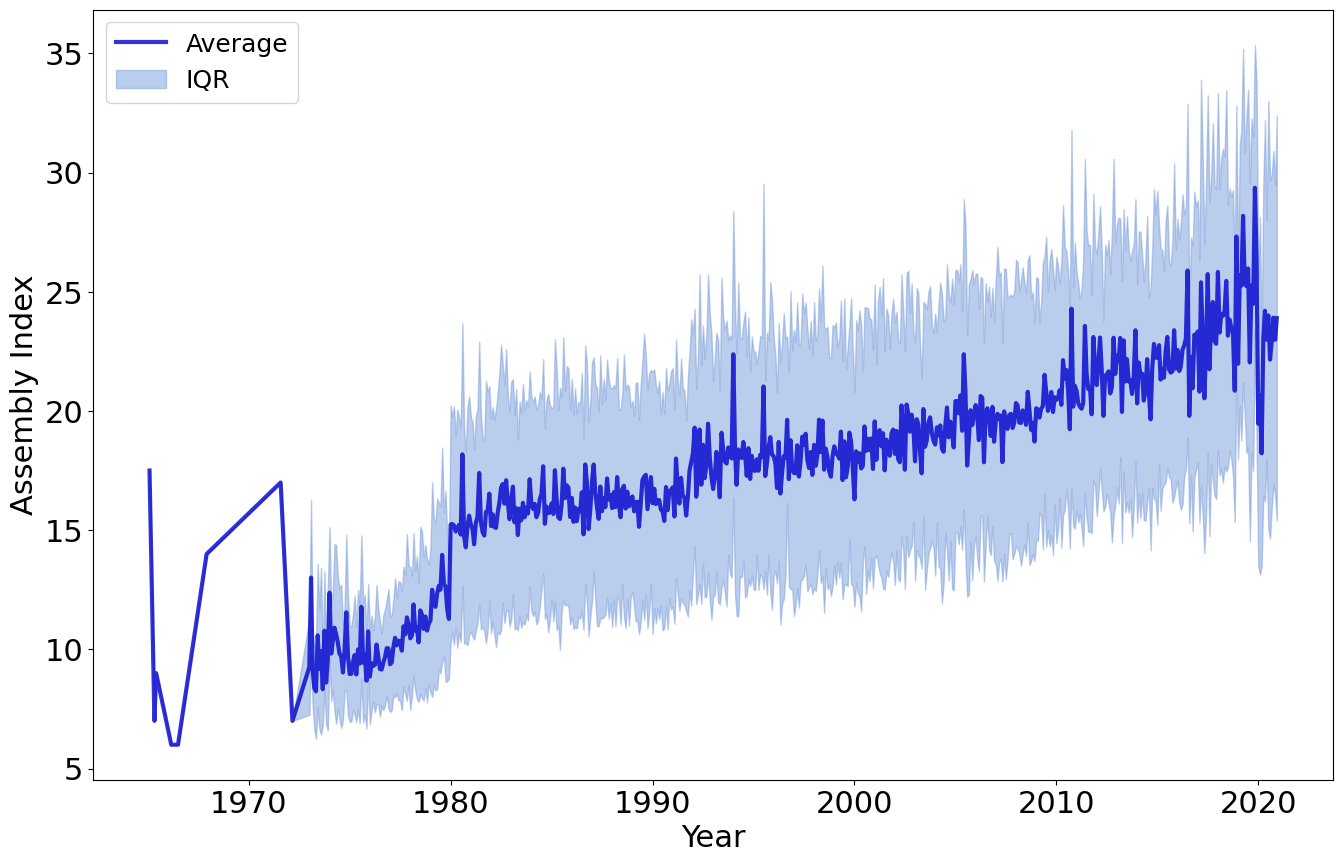

In [14]:
#Assembly values with standard deviation

import matplotlib.ticker as plticker


plt.figure(figsize=(16,10))

plt.plot(MA_df_months["date"], MA_df_months["avg"], color="mediumblue",
            linewidth=3, markersize=10, alpha=0.8, label="Average")

plt.fill_between(MA_df_months["date"], MA_df_months["avg"] + MA_df_months["iqr"]/2, 
                MA_df_months["avg"] - MA_df_months["iqr"]/2, alpha=0.5, color=palette[6],
                label="IQR")

plt.legend(loc="upper left", prop={"size":"18"})
plt.xlabel("Year")
plt.ylabel("Assembly Index")

## Set up molecular weight figure

In [15]:
## Read molecular weight df (obtained from full surechembl database)
filtered_sc_df = pd.read_csv("../Data/molecular_weight_chemblCpds.csv")

In [16]:
#Merge with MA results to link dates with MW

mw_df = pd.merge(left=MA_df, right=filtered_sc_df, left_on="label", right_on="SureChEMBL_ID", how="outer")

print(mw_df)

         Unnamed: 0_x  Unnamed: 0.1            label  MA_assemblyGo  \
0                   0             0        SCHEMBL10           21.0   
1                   1             1  SCHEMBL10000006           14.0   
2                   2             2  SCHEMBL10000077           19.0   
3                   3             3  SCHEMBL10000078           10.0   
4                   4             4  SCHEMBL10000080            6.0   
...               ...           ...              ...            ...   
2034436        473226         13048  SCHEMBL21609983           25.0   
2034437        473227         13049  SCHEMBL21610001            7.0   
2034438        473228         13050  SCHEMBL21610027          133.0   
2034439        473229         13051  SCHEMBL21610072            8.0   
2034440        473231         13053  SCHEMBL21610114           27.0   

               time earliest_date  date_ordinal    month  Unnamed: 0_y  \
0        120.662484    1980-06-25        722991  1980-06           2.0   

Statistics over each month

In [17]:
MW_df_months = mw_df.groupby("month")["mw"].apply(list).reset_index(name="MWs")

tqdm.pandas() 

MW_df_months["avg"] = MW_df_months["MWs"].progress_apply(get_mean)
MW_df_months["std"] = MW_df_months["MWs"].progress_apply(get_std)
MW_df_months["iqr"] = MW_df_months["MWs"].progress_apply(get_IQR)

#Change dates to ordinals
MW_df_months["date"] = pd.to_datetime(MW_df_months["month"])
MW_df_months["date_ordinal"] = MW_df_months["date"].map(dt.datetime.toordinal)

100%|██████████| 585/585 [00:00<00:00, 1518.55it/s]


In [23]:
print(MW_df_months)

       month                                                MWs         avg  \
0    1965-02             [416.3290452679999, 416.3290452679999]  416.329045   
1    1965-05                                    [144.068748256]  144.068748   
2    1965-06                                    [144.068748256]  144.068748   
3    1966-03                                    [199.045570288]  199.045570   
4    1966-07                                    [117.057849224]  117.057849   
..       ...                                                ...         ...   
580  2020-09  [462.03967232000014, 398.05058590000016, 402.0...  488.736131   
581  2020-10  [228.13615912, 276.13615912, 219.104799416, 21...  509.775539   
582  2020-11  [239.97602608, 268.007326208, 212.131348512000...  482.549266   
583  2020-12  [240.099773612, 909.4097494760001, 297.0848518...  504.430762   
584      NaT  [nan, 204.08987762400002, 613.769650768, 160.0...         NaN   

            std         iqr       date  date_ordina

Text(0, 0.5, 'Molecular Weight (Daltons)')

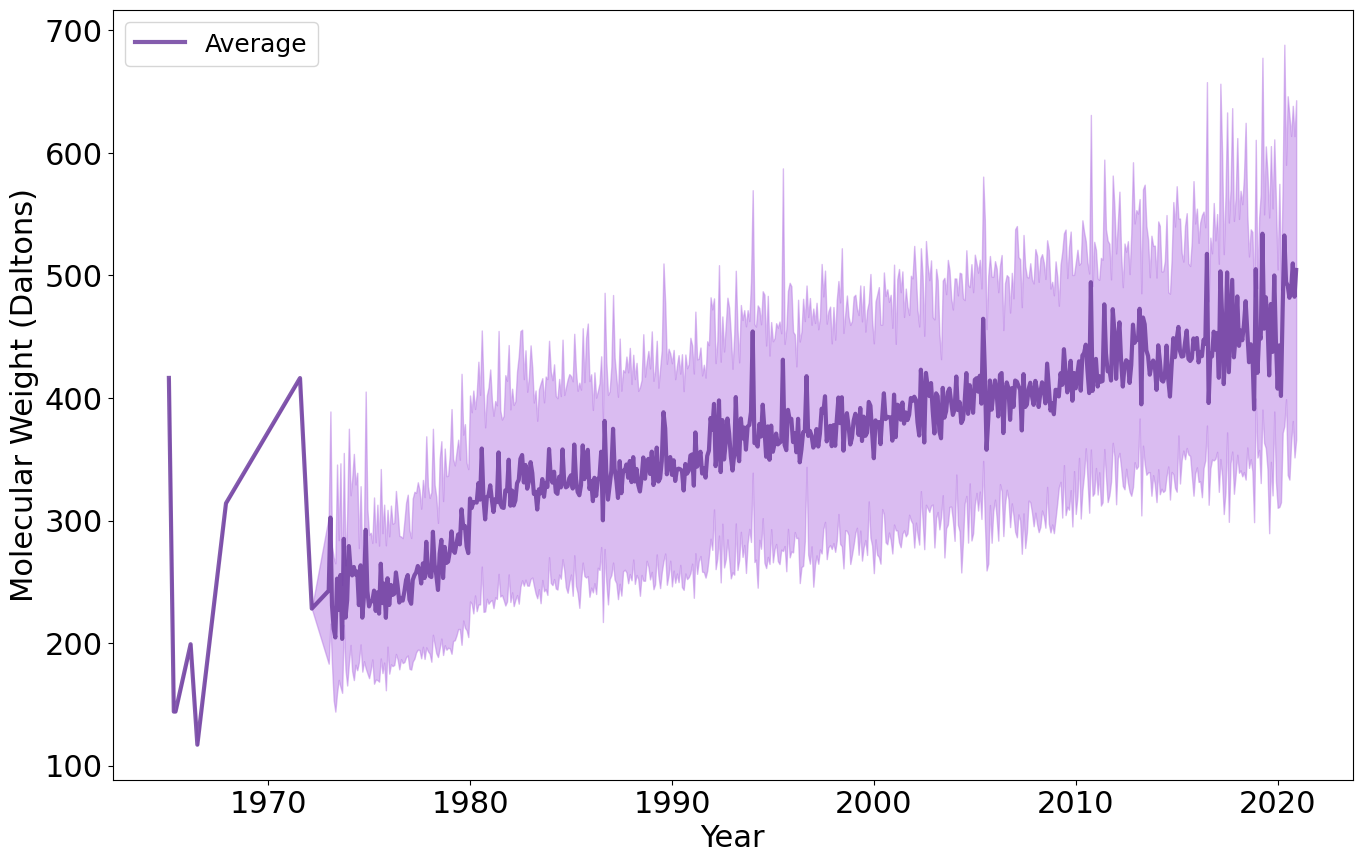

In [18]:
#Assembly values with standard deviation

import matplotlib.ticker as plticker


plt.figure(figsize=(16,10))

plt.plot(MW_df_months["date"], MW_df_months["avg"], color="rebeccapurple",
            linewidth=3, markersize=10, alpha=0.8, label="Average")

plt.fill_between(MW_df_months["date"], MW_df_months["avg"] + MW_df_months["iqr"]/2, 
                MW_df_months["avg"] - MW_df_months["iqr"]/2, alpha=0.5, color=palette[4],
                label="")

plt.legend(loc="upper left", prop={"size":"18"})
plt.xlabel("Year")
plt.ylabel("Molecular Weight (Daltons)")

## Fragment figure

In [19]:
new_frag_count = pickle.load(file=open("../Data/AssemblyValues/Fragments/author_newFragCount.p", "rb"))

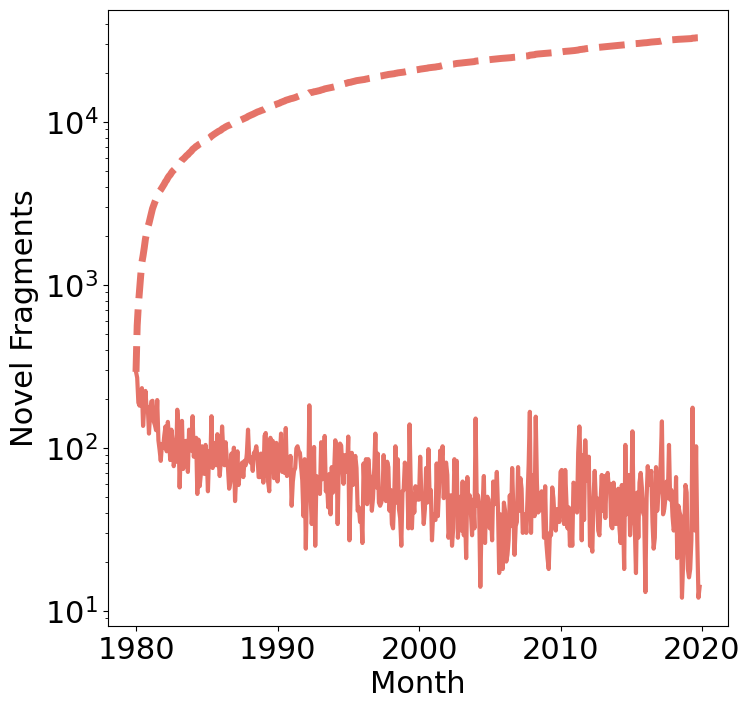

In [20]:
plt.figure(figsize=(8,8))


plt.plot(list(np.arange(1980, 2020, 1/12))[:-1], new_frag_count, 
         linewidth=3, color=palette[5])

plt.plot(list(np.arange(1980, 2020, 1/12))[:-1], np.cumsum(new_frag_count), 
         linewidth=5, color=palette[5], linestyle="--")

plt.yscale("log")

plt.xlabel("Month")
plt.ylabel("Novel Fragments")

plt.show()

## Full Figure

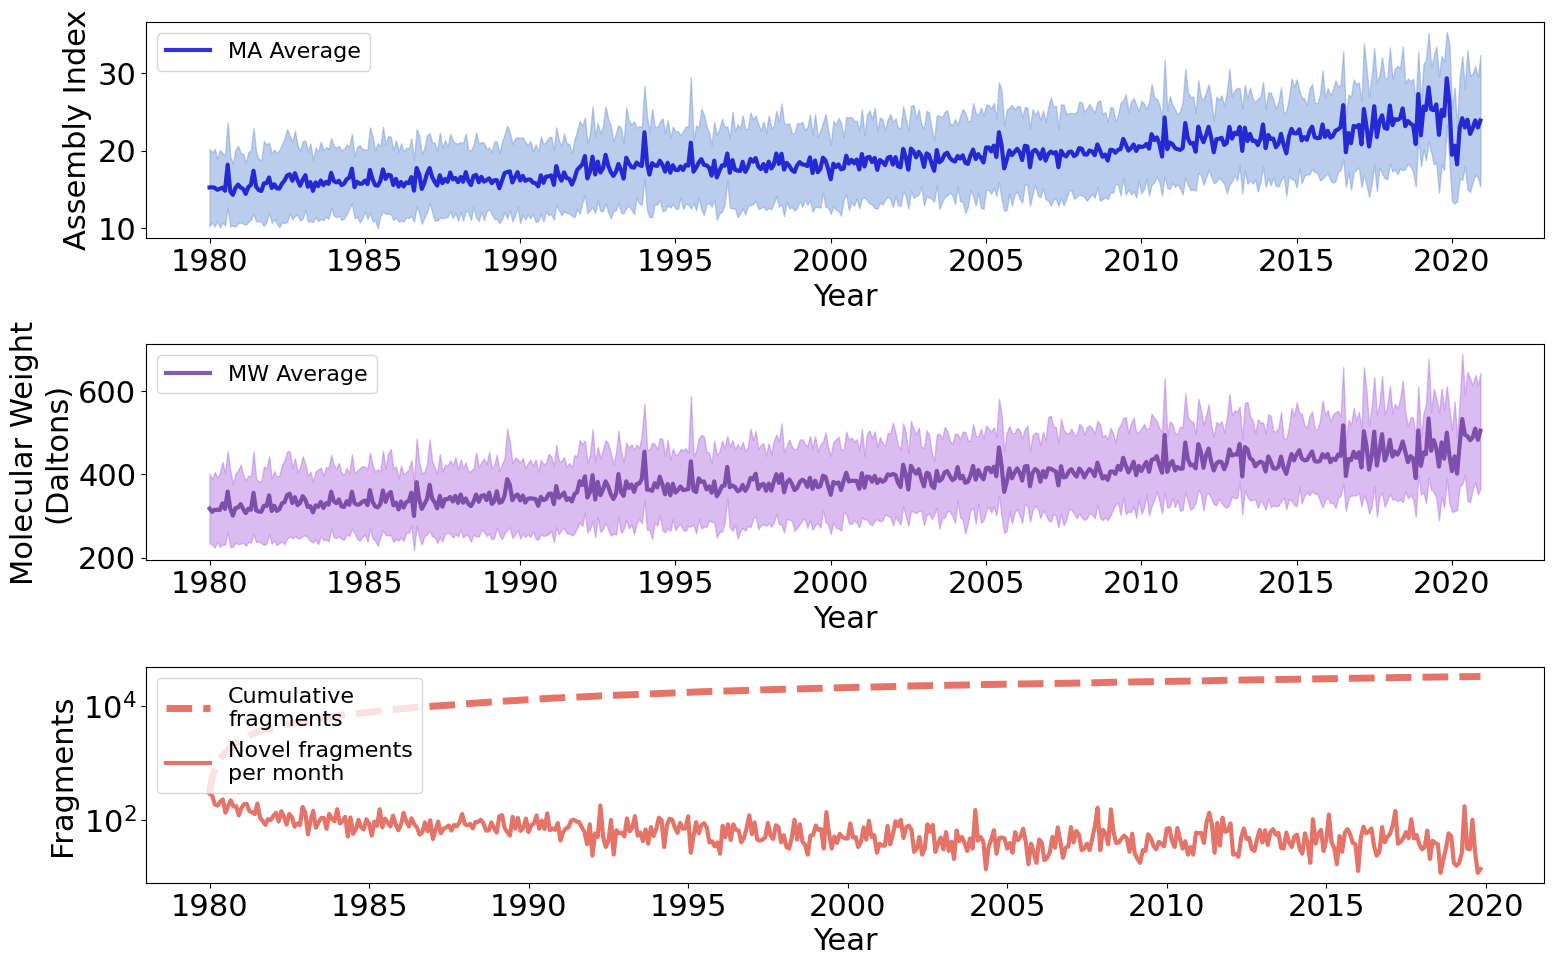

In [30]:
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(3,3)

fig = plt.figure(figsize=(16,10))

## MA Figure
ax1 = fig.add_subplot(gs[0,:])

MA_df_months_filtered = MA_df_months[MA_df_months["date"] >= "1980"]
ax1.plot(MA_df_months_filtered["date"], MA_df_months_filtered["avg"], color="mediumblue",
            linewidth=3, markersize=10, alpha=0.8, label="MA Average")

ax1.fill_between(MA_df_months_filtered["date"], MA_df_months_filtered["avg"] + MA_df_months_filtered["iqr"]/2, 
                MA_df_months_filtered["avg"] - MA_df_months_filtered["iqr"]/2, alpha=0.5, color=palette[6],)

ax1.legend(loc="upper left", prop={"size":"16"})
ax1.set_xlabel("Year")
ax1.set_ylabel("Assembly Index")


## MW Figure
ax2 = fig.add_subplot(gs[1,:])

MW_df_months_filtered = MW_df_months[MW_df_months["date"] >= "1980"]
ax2.plot(MW_df_months_filtered["date"], MW_df_months_filtered["avg"], color="rebeccapurple",
            linewidth=3, markersize=10, alpha=0.8, label="MW Average")

ax2.fill_between(MW_df_months_filtered["date"], MW_df_months_filtered["avg"] + MW_df_months_filtered["iqr"]/2, 
                MW_df_months_filtered["avg"] - MW_df_months_filtered["iqr"]/2, alpha=0.5, color=palette[4])

ax2.legend(loc="upper left", prop={"size":"16"})
ax2.set_xlabel("Year")
ax2.set_ylabel("Molecular Weight\n(Daltons)")


## Fragment figure
ax3 = fig.add_subplot(gs[2,:])

ax3.plot(list(np.arange(1980, 2020, 1/12))[:-1], np.cumsum(new_frag_count), 
         linewidth=5, color=palette[5], linestyle="--", label="Cumulative\nfragments")

ax3.plot(list(np.arange(1980, 2020, 1/12))[:-1], new_frag_count, 
         linewidth=3, color=palette[5], label="Novel fragments\nper month")



ax3.set_yscale("log")

ax3.legend(loc="upper left", prop={"size":"16"})
ax3.set_xlabel("Year")
ax3.set_ylabel("Fragments")
#ax3.set_ylim(1980, 2022)

plt.tight_layout()


## Statistics over MA & MW

Linear regressions & basic stats over both time-series data

In [32]:
import scipy.stats as stats
import statsmodels.api as sm

In [68]:
#Basic linear regression & statistics over MA distribution

MA_slope, MA_intercept = np.polyfit(MA_df_months_filtered["date_ordinal"], MA_df_months_filtered["avg"], 1)

##Calculate Spearman correlation (not assuming normality)
MA_spearman_corr = stats.spearmanr(MA_df_months_filtered["date_ordinal"], MA_df_months_filtered["avg"])

print("Slope:", MA_slope) 
print("Intercept:", MA_intercept)
print(MA_spearman_corr)

Slope: 0.0005635115496634127
Intercept: -392.5664362458797
SpearmanrResult(correlation=0.9332106950992297, pvalue=5.9993967989674065e-220)


In [38]:
#Basic linear regression & statistics over MW distribution

MW_slope, MW_intercept = np.polyfit(MW_df_months_filtered["date_ordinal"], MW_df_months_filtered["avg"], 1)

##Calculate Spearman correlation (not assuming normality)
MW_spearman_corr = stats.spearmanr(MW_df_months_filtered["date_ordinal"], MW_df_months_filtered["avg"])

print("Slope:", MW_slope) 
print("Intercept:", MW_intercept)
print(MW_spearman_corr)

Slope: 0.009760451120408228
Intercept: -6740.516328760418
SpearmanrResult(correlation=0.9284905975394634, pvalue=6.108958527597679e-213)


[715000.0, 717500.0, 720000.0, 722500.0, 725000.0, 727500.0, 730000.0, 732500.0, 735000.0, 737500.0, 740000.0]


/Users/John/anaconda2/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


[Text(715000.0, 0, '1958'),
 Text(717500.0, 0, '1965'),
 Text(720000.0, 0, '1972'),
 Text(722500.0, 0, '1979'),
 Text(725000.0, 0, '1985'),
 Text(727500.0, 0, '1992'),
 Text(730000.0, 0, '1999'),
 Text(732500.0, 0, '2006'),
 Text(735000.0, 0, '2013'),
 Text(737500.0, 0, '2020'),
 Text(740000.0, 0, '2027')]

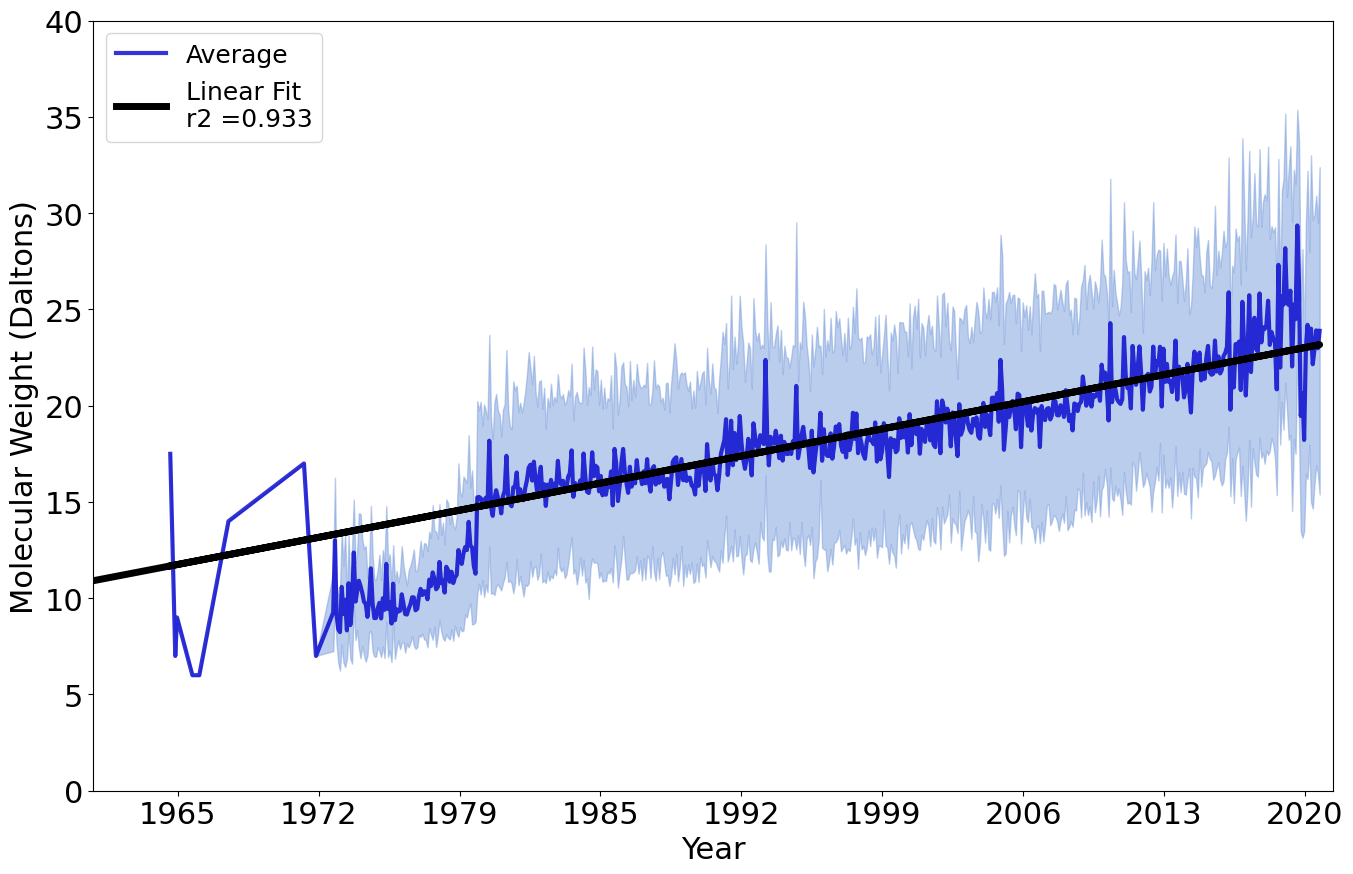

In [72]:
#MW graphing with linear regression

import matplotlib.ticker as plticker


fig, ax = plt.subplots(figsize=(16,10))

plt.plot(MA_df_months["date_ordinal"], MA_df_months["avg"], color="mediumblue",
            linewidth=3, markersize=10, alpha=0.8, label="Average")

plt.fill_between(MA_df_months["date_ordinal"], MA_df_months["avg"] + MA_df_months["iqr"]/2, 
                MA_df_months["avg"] - MA_df_months["iqr"]/2, alpha=0.5, color=palette[6],
                label="")

## Linear regression
plt.plot(MA_df_months["date_ordinal"], MA_slope * MA_df_months["date_ordinal"] + MA_intercept, color="k", linewidth=5,
        label="Linear Fit\nr2 =" + str(round(MA_spearman_corr[0], 3)))

plt.legend(loc="upper left", prop={"size":"18"})
plt.xlabel("Year")
plt.ylabel("Molecular Weight (Daltons)")
plt.xlim(716000, 738000)
plt.ylim(0,40)

a=ax.get_xticks().tolist()
xticks = [dt.datetime.fromordinal(int(x)).year for x in a]
ax.set_xticklabels(xticks)

[715000.0, 717500.0, 720000.0, 722500.0, 725000.0, 727500.0, 730000.0, 732500.0, 735000.0, 737500.0, 740000.0]


/Users/John/anaconda2/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


[Text(715000.0, 0, '1958'),
 Text(717500.0, 0, '1965'),
 Text(720000.0, 0, '1972'),
 Text(722500.0, 0, '1979'),
 Text(725000.0, 0, '1985'),
 Text(727500.0, 0, '1992'),
 Text(730000.0, 0, '1999'),
 Text(732500.0, 0, '2006'),
 Text(735000.0, 0, '2013'),
 Text(737500.0, 0, '2020'),
 Text(740000.0, 0, '2027')]

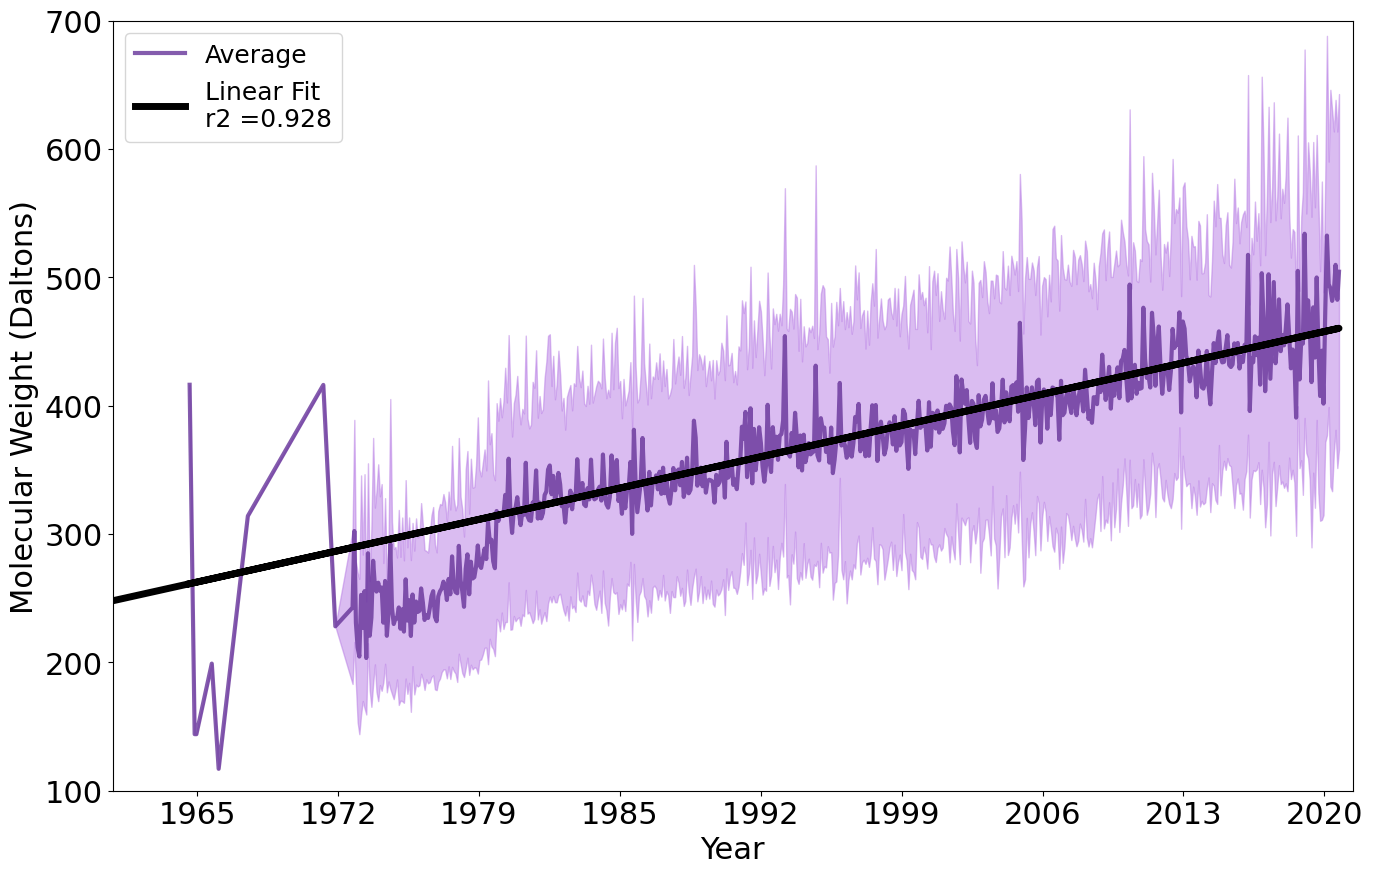

In [71]:
#MW graphing with linear regression

import matplotlib.ticker as plticker


fig, ax = plt.subplots(figsize=(16,10))

plt.plot(MW_df_months["date_ordinal"], MW_df_months["avg"], color="rebeccapurple",
            linewidth=3, markersize=10, alpha=0.8, label="Average")

plt.fill_between(MW_df_months["date_ordinal"], MW_df_months["avg"] + MW_df_months["iqr"]/2, 
                MW_df_months["avg"] - MW_df_months["iqr"]/2, alpha=0.5, color=palette[4],
                label="")

## Linear regression
plt.plot(MW_df_months["date_ordinal"], MW_slope * MW_df_months["date_ordinal"] + MW_intercept, color="k", linewidth=5,
        label="Linear Fit\nr2 =" + str(round(MW_spearman_corr[0], 3)))

plt.legend(loc="upper left", prop={"size":"18"})
plt.xlabel("Year")
plt.ylabel("Molecular Weight (Daltons)")
plt.xlim(716000, 738000)
plt.ylim(100,700)

a=ax.get_xticks().tolist()
print(a)
xticks = [dt.datetime.fromordinal(int(x)).year for x in a]
ax.set_xticklabels(xticks)

## Values of MA/MW at specific dates

For right now, looking for:
- Average MA & MW at Jan 1976 and Dec 2020

In [75]:
print(MA_df_months[MA_df_months["month"] == "1976-01"])
print()
print(MA_df_months[MA_df_months["month"] == "2020-12"])

      month                                                MAs       avg  \
44  1976-01  [8.0, 16.0, 8.0, 8.0, 8.0, 9.0, 5.0, 9.0, 8.0,...  8.857341   

         std  iqr       date  date_ordinal  
44  4.343837  4.0 1976-01-01        721354  

       month                                                MAs        avg  \
583  2020-12  [9.0, 46.0, 14.0, 46.0, 7.0, 47.0, 41.0, 41.0,...  23.890889   

          std   iqr       date  date_ordinal  
583  11.05373  17.0 2020-12-01        737760  


In [76]:
print(MW_df_months[MW_df_months["month"] == "1976-01"])
print()
print(MW_df_months[MW_df_months["month"] == "2020-12"])

      month                                                MWs         avg  \
44  1976-01  [260.18100113599996, 338.1338676759998, 259.14...  231.060836   

           std         iqr       date  date_ordinal  
44  109.923037  112.020308 1976-01-01        721354  

       month                                                MWs         avg  \
583  2020-12  [240.099773612, 909.4097494760001, 297.0848518...  504.430762   

            std        iqr       date  date_ordinal  
583  204.926171  276.87106 2020-12-01        737760  


## Statistics over fragments

Test:
- Linearity of fragments (when does it become linear)
- Others?

In [ ]:
## Test for when r2 of linear regression doesn't change...
rsquares = []

for i in range(len(new_frag_count)):
    #